<a href="https://colab.research.google.com/github/mattfarrow1/7331-machine-learning-1/blob/main/Labs/MiniProject_Group4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini-Project: SVM & Logistic Regression Classification

Matt Farrow, Amber Clark, Blake Freeman, Megan Ball

## **2015 Flight Delays and Cancellations**
Data Source: [Kaggle](https://www.kaggle.com/usdot/flight-delays?select=flights.csv)

Our group's Mini Project uses the same data that we explored during [Lab 1](https://nbviewer.jupyter.org/github/mattfarrow1/7331-machine-learning-1/blob/main/Labs/Lab1_Group4.ipynb), which you'll recall came from the U.S. Department of Transportation's Bureau of Transportation Statistics and "tracks the on-time performance of domestic flights operated by large air carriers" during 2015 [Kaggle](https://www.kaggle.com/usdot/flight-delays). 

Our logistic regression and support vector machine models will focus on classifying flights using arrival delay as our response variable. As we noted in Lab 1's Business Understanding section, "Arrival delay serves as the total delay experienced by the flight and accounts for previous delays as well as time that pilots were able to make up in the air."

## 1. Logistic Regression & Support Vector Machine Models

> [50 points] Create a logistic regression model and a support vector machine model for the
classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use.

### 1.1 Setup & Load Data

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import altair as alt

# Due to the way these columns are formatted, we want to keep the leading zeros during our import. 
# Later on we will convert them to a time format.
dtype_t = {'SCHEDULED_DEPARTURE': str,
           'DEPARTURE_TIME': str,
           'WHEELS_OFF': str,
           'SCHEDULED_TIME': str,
           'WHEELS_ON': str,
           'SCHEDULED_ARRIVAL': str,
           'ARRIVAL_TIME': str
          }

# Read in the data directly
airlines = pd.read_csv('../Data/airlines.csv')
airports = pd.read_csv('../Data/airports.csv')
flights  = pd.read_csv('../Data/flights.csv', dtype = dtype_t)

# Read in the data directly from GitHub
# airlines = pd.read_csv('https://raw.githubusercontent.com/mattfarrow1/7331-machine-learning-1/main/Data/airlines.csv')
# airports = pd.read_csv('https://raw.githubusercontent.com/mattfarrow1/7331-machine-learning-1/main/Data/airports.csv')
# flights  = pd.read_csv('https://media.githubusercontent.com/media/mattfarrow1/7331-machine-learning-1/main/Data/flights.csv', dtype = dtype_t)

/Users/mattfarrow/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
# Rename columns in preparation for merge
airlines.rename(columns={'IATA_CODE': 'AIRLINE_CODE'}, inplace=True)
flights.rename(columns={'AIRLINE': 'AIRLINE_CODE'}, inplace=True)

# Merge data together
df = pd.merge(flights, airlines, on='AIRLINE_CODE', how = 'left')

# Convert string columns to datetime
cols = ["WHEELS_OFF",  
        "WHEELS_ON"] 
df[cols] = df[cols].apply(pd.to_datetime, format = '%H%M', errors='coerce')

# Convert time to numeric for binning of the other times
cols = ["SCHEDULED_DEPARTURE", 
        "DEPARTURE_TIME", 
        "SCHEDULED_ARRIVAL", 
        "ARRIVAL_TIME"]
df[cols] = df[cols].apply(pd.to_numeric)

### 1.2 Create New Variables

The data contains several timestamp and continuous variables that add additional complexity. In order to simplify the data, we will create buckets where appropriate to analyze similar attributes together. 

We first convert `SCHEDULED_DEPARTURE`, `DEPARTURE_TIME`, `SCHEDULED_ARRIVAL`, and `ARRIVAL_TIME` into buckets based on their timestamp. 

- **Overnight**: 12:00am - 4:00am
- **Morning**: 4:00am - 11:00am
- **Afternoon**: 11:00am - 4:00pm
- **Evening**: 4:00pm - 12:00am

In [3]:
# Convert times into buckets for morning, afternoon, and evening as most models cannot handle timestamps.
cut_labels = ['overnight', 'morning', 'afternoon', 'evening']
cut_bins = [0, 400, 1100, 1600, 2359]

df['SCHED_DEPARTURE_TIME'] = pd.cut(df['SCHEDULED_DEPARTURE'], 
                                    bins=cut_bins, 
                                    labels=cut_labels, 
                                    include_lowest=True)
df['ACTUAL_DEPARTURE_TIME'] = pd.cut(df['DEPARTURE_TIME'], 
                                     bins=cut_bins, 
                                     labels=cut_labels, 
                                     include_lowest=True)
df['SCHED_ARRIVAL_TIME'] = pd.cut(df['SCHEDULED_ARRIVAL'], 
                                  bins=cut_bins, 
                                  labels=cut_labels, 
                                  include_lowest=True)
df['ACTUAL_ARRIVAL_TIME'] = pd.cut(df['ARRIVAL_TIME'], 
                                   bins=cut_bins, 
                                   labels=cut_labels, 
                                   include_lowest=True)

# Look at our data with the buckets
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE,SCHED_DEPARTURE_TIME,ACTUAL_DEPARTURE_TIME,SCHED_ARRIVAL_TIME,ACTUAL_ARRIVAL_TIME
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,NaN,NaN,NaN,NaN,NaN,Alaska Airlines Inc.,overnight,evening,morning,morning
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.,overnight,overnight,morning,morning
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,NaN,NaN,NaN,NaN,NaN,US Airways Inc.,overnight,overnight,morning,morning
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.,overnight,overnight,morning,morning
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,NaN,NaN,NaN,NaN,NaN,Alaska Airlines Inc.,overnight,overnight,overnight,overnight


In [4]:
# Check how many of each bin we have
actual_arrival = df['ACTUAL_ARRIVAL_TIME'].value_counts()
sched_depart = df['SCHED_DEPARTURE_TIME'].value_counts()
actual_depart = df['ACTUAL_DEPARTURE_TIME'].value_counts()
sched_arrival = df['SCHED_ARRIVAL_TIME'].value_counts()

print(actual_arrival, '\n\n', sched_depart, '\n\n', actual_depart, '\n\n', sched_arrival)

evening      2593316
afternoon    1688115
morning      1299286
overnight     143393
Name: ACTUAL_ARRIVAL_TIME, dtype: int64 

 morning      2056248
evening      1971869
afternoon    1768922
overnight      22040
Name: SCHED_DEPARTURE_TIME, dtype: int64 

 evening      1999032
morning      1978882
afternoon    1716939
overnight      37560
Name: ACTUAL_DEPARTURE_TIME, dtype: int64 

 evening      2676736
afternoon    1735865
morning      1317709
overnight      88767
Name: SCHED_ARRIVAL_TIME, dtype: int64


[Flight] `DISTANCE` and `ARRIVAL_DELAY` are also divided into buckets.

#### Distance
- **Short**: 1-99 miles
- **Medium**: 100-999 miles
- **Long**: 1,000+ miles

#### Arrival Delay
- **Early**: Prior to scheduled arrival time
- **On-Time**: Within 0-29 minutes of scheduled arrival
- **30-59**: Within 30-59 minutes of scheduled arrival time
- **60-89**: Within 60-89 minutes of scheduled arrival time
- **90-119**: Within 90-119 minutes of scheduled arrival time
- **120+**: More than 120 minutes after scheduled arrival time

In [5]:
# Bucket Flight Distance
distance_labels = ['Short', 'Medium', 'Long']
distance_bins   = [1, 100, 1000, np.inf]
df['DISTANCE_BUCKET'] = pd.cut(df['DISTANCE'],
                               bins=distance_bins,
                               labels=distance_labels)

# Bucket Arrival Delay
delay_labels = ['Early', 'On-Time', '30-59', '60-89', '90-119', '120+']
delay_bins   = [-np.inf, 0, 30, 60, 90, 120, np.inf]
df['ARRIVAL_DELAY_BUCKET'] = pd.cut(df['ARRIVAL_DELAY'],
                                    bins=delay_bins,
                                    labels=delay_labels)

In [6]:
# Check bin sizes
print(df['DISTANCE_BUCKET'].value_counts())
print(df['ARRIVAL_DELAY_BUCKET'].value_counts())

Medium    4102644
Long      1646627
Short       69808
Name: DISTANCE_BUCKET, dtype: int64
Early      3627112
On-Time    1454199
30-59       313605
60-89       133030
120+        114420
90-119       71642
Name: ARRIVAL_DELAY_BUCKET, dtype: int64


### 1.3 Missing Values

In [7]:
%%time
# Convert missing values to 'N' for 'N/A'
df['CANCELLATION_REASON'] = df['CANCELLATION_REASON'].fillna('N')

# Update missing values in times to 0. 
# Will be updating times to a binary (1 = yes action happened, 0 = no action happened)
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].fillna(0)

# Change all non-null values to 1
df.loc[(df.DEPARTURE_TIME != '0'), 'DEPARTURE_TIME'] = 1

# Change column name to 'DEPARTED'
df.rename(columns={'DEPARTURE_TIME': 'DEPARTED'}, inplace=True)

# Update remaining columns using same logic
cols = ['WHEELS_OFF','WHEELS_ON','ARRIVAL_TIME']
df[cols] = df[cols].fillna(0)
df.loc[(df.WHEELS_OFF != '0'), 'WHEELS_OFF'] = 1
df.loc[(df.WHEELS_ON != '0'), 'WHEELS_ON'] = 1
df.loc[(df.ARRIVAL_TIME != '0'), 'ARRIVAL_TIME'] = 1
df.rename(columns={'ARRIVAL_TIME': 'ARRIVED'}, inplace=True)

# Fill missing values with 0
cols = ['AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY','LATE_AIRCRAFT_DELAY','WEATHER_DELAY']
df[cols] = df[cols].fillna(0)

# Change remaining null values to 0 if flight was cancelled
df.loc[(df.CANCELLED == 1), ('DEPARTURE_DELAY', 'TAXI_OUT', 'ELAPSED_TIME','AIR_TIME','TAXI_IN','ARRIVAL_DELAY')] = 0

# Remove remaining null values
df = df.dropna()

CPU times: user 1min 15s, sys: 1.54 s, total: 1min 16s
Wall time: 1min 16s


### 1.4 Log Transformations

As we discovered during Lab 1, the `DEPARTURE_DELAY`, `ARRIVAL_DELAY`, `DISTANCE`, `TAXI_IN`, `ELAPSED_TIME`, and `AIR_TIME` variables are siginificantly right-skewed with a large number of outliers. In order to normalize these values, we did a log transformation.

In [8]:
# Log transformation keeping the 0 in the data sets 
df["DEPARTURE_DELAY_log"] = df["DEPARTURE_DELAY"].map(lambda i: np.log1p(i) if i > 0 else 0) 
df["ARRIVAL_DELAY_Log"]   = df["ARRIVAL_DELAY"].map(lambda i: np.log1p(i) if i > 0 else 0)
df["DISTANCE_log"]        = df["DISTANCE"].map(lambda i: np.log1p(i) if i > 0 else 0) 
df["TAXI_IN_Log"]         = df["TAXI_IN"].map(lambda i: np.log1p(i) if i > 0 else 0)
df["ELAPSED_TIME_log"]    = df["ELAPSED_TIME"].map(lambda i: np.log1p(i) if i > 0 else 0) 
df["AIR_TIME_log"]        = df["AIR_TIME"].map(lambda i: np.log1p(i) if i > 0 else 0) 

In [9]:
# Check our current columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5711054 entries, 0 to 5819078
Data columns (total 44 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   YEAR                   int64   
 1   MONTH                  int64   
 2   DAY                    int64   
 3   DAY_OF_WEEK            int64   
 4   AIRLINE_CODE           object  
 5   FLIGHT_NUMBER          int64   
 6   TAIL_NUMBER            object  
 7   ORIGIN_AIRPORT         object  
 8   DESTINATION_AIRPORT    object  
 9   SCHEDULED_DEPARTURE    int64   
 10  DEPARTED               float64 
 11  DEPARTURE_DELAY        float64 
 12  TAXI_OUT               float64 
 13  WHEELS_OFF             object  
 14  SCHEDULED_TIME         object  
 15  ELAPSED_TIME           float64 
 16  AIR_TIME               float64 
 17  DISTANCE               int64   
 18  WHEELS_ON              object  
 19  TAXI_IN                float64 
 20  SCHEDULED_ARRIVAL      int64   
 21  ARRIVED                float64 

In [10]:
# Look at the head of all columns
pd.set_option('display.max_columns', None)
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTED,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVED,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE,SCHED_DEPARTURE_TIME,ACTUAL_DEPARTURE_TIME,SCHED_ARRIVAL_TIME,ACTUAL_ARRIVAL_TIME,DISTANCE_BUCKET,ARRIVAL_DELAY_BUCKET,DEPARTURE_DELAY_log,ARRIVAL_DELAY_Log,DISTANCE_log,TAXI_IN_Log,ELAPSED_TIME_log,AIR_TIME_log
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,1.0,-11.0,21.0,1,205,194.0,169.0,1448,1,4.0,430,1.0,-22.0,0,0,N,0.0,0.0,0.0,0.0,0.0,Alaska Airlines Inc.,overnight,evening,morning,morning,Long,Early,0.0,0.000000,7.278629,1.609438,5.273000,5.135798
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,1.0,-8.0,12.0,1,280,279.0,263.0,2330,1,4.0,750,1.0,-9.0,0,0,N,0.0,0.0,0.0,0.0,0.0,American Airlines Inc.,overnight,overnight,morning,morning,Long,Early,0.0,0.000000,7.754053,1.609438,5.634790,5.575949
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,1.0,-2.0,16.0,1,286,293.0,266.0,2296,1,11.0,806,1.0,5.0,0,0,N,0.0,0.0,0.0,0.0,0.0,US Airways Inc.,overnight,overnight,morning,morning,Long,On-Time,0.0,1.791759,7.739359,2.484907,5.683580,5.587249
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,1.0,-5.0,15.0,1,285,281.0,258.0,2342,1,8.0,805,1.0,-9.0,0,0,N,0.0,0.0,0.0,0.0,0.0,American Airlines Inc.,overnight,overnight,morning,morning,Long,Early,0.0,0.000000,7.759187,2.197225,5.641907,5.556828
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,1.0,-1.0,11.0,1,235,215.0,199.0,1448,1,5.0,320,1.0,-21.0,0,0,N,0.0,0.0,0.0,0.0,0.0,Alaska Airlines Inc.,overnight,overnight,overnight,overnight,Long,Early,0.0,0.000000,7.278629,1.791759,5.375278,5.298317


In [11]:
# Convert scheduled time to be a numeric instead of an object.
df['SCHEDULED_TIME'] = pd.to_numeric(df['SCHEDULED_TIME'])

### 1.5 Create Response Variable

In [12]:
# Create a new column where the arrival_delay > 0 means it's delayed(=1) and if <= 0 it's not delayed(=0)
get_delay = lambda x: 0 if x <= 0 else 1
df['DELAYED'] = df.ARRIVAL_DELAY.apply(get_delay)

### 1.6 Remove Non-Cancelled Flights

Flights that are cancelled will, by their nature, not have an arrival delay. Therefore we remove those so that we are left with only the flights that were completed. 

In [13]:
df = df[df.CANCELLED == 0]

In [14]:
df.shape

(5711054, 45)

In [15]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTED,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVED,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE,SCHED_DEPARTURE_TIME,ACTUAL_DEPARTURE_TIME,SCHED_ARRIVAL_TIME,ACTUAL_ARRIVAL_TIME,DISTANCE_BUCKET,ARRIVAL_DELAY_BUCKET,DEPARTURE_DELAY_log,ARRIVAL_DELAY_Log,DISTANCE_log,TAXI_IN_Log,ELAPSED_TIME_log,AIR_TIME_log,DELAYED
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,1.0,-11.0,21.0,1,205,194.0,169.0,1448,1,4.0,430,1.0,-22.0,0,0,N,0.0,0.0,0.0,0.0,0.0,Alaska Airlines Inc.,overnight,evening,morning,morning,Long,Early,0.0,0.000000,7.278629,1.609438,5.273000,5.135798,0
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,1.0,-8.0,12.0,1,280,279.0,263.0,2330,1,4.0,750,1.0,-9.0,0,0,N,0.0,0.0,0.0,0.0,0.0,American Airlines Inc.,overnight,overnight,morning,morning,Long,Early,0.0,0.000000,7.754053,1.609438,5.634790,5.575949,0
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,1.0,-2.0,16.0,1,286,293.0,266.0,2296,1,11.0,806,1.0,5.0,0,0,N,0.0,0.0,0.0,0.0,0.0,US Airways Inc.,overnight,overnight,morning,morning,Long,On-Time,0.0,1.791759,7.739359,2.484907,5.683580,5.587249,1
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,1.0,-5.0,15.0,1,285,281.0,258.0,2342,1,8.0,805,1.0,-9.0,0,0,N,0.0,0.0,0.0,0.0,0.0,American Airlines Inc.,overnight,overnight,morning,morning,Long,Early,0.0,0.000000,7.759187,2.197225,5.641907,5.556828,0
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,1.0,-1.0,11.0,1,235,215.0,199.0,1448,1,5.0,320,1.0,-21.0,0,0,N,0.0,0.0,0.0,0.0,0.0,Alaska Airlines Inc.,overnight,overnight,overnight,overnight,Long,Early,0.0,0.000000,7.278629,1.791759,5.375278,5.298317,0


### 1.7 Feature Removals

<span style="color: red;">Based on our work in Lab 1, there are a number of columns that we previously identified as either being redundant or not useful for our classification models. Therefore, we made the decision to remove the following unnecessary variables from our data set:</span>

<span style="color: red;">All of the flights take place during 2015, so there is no need to include `YEAR`. In merging the airline information in with the flight data we now have the `AIRLINE` name which means we can remove the more difficult to decipher `AIRLINE_CODE`. Since we are analyzing flight delays, `CANCELLATION_REASON` and `CANCELLED` are not needed.</span>

<span style="color: red;">During Lab 1, we made the decision to convert `WHEELS_ON` and `WHEELS_OFF` from time stamp data into binary values. Since all flights took off, these values will all be `1` and therefore not helpful for classification. Similarly, `DEPARTED` and `ARRIVED` are binary values and are not needed as all will be equal to `1` after removing the cancelled flights.</span>

In [16]:
col_to_drop = ['YEAR','AIRLINE','SCHEDULED_DEPARTURE','SCHEDULED_ARRIVAL',
               'CANCELLED', 'CANCELLATION_REASON', 'WHEELS_ON', 'WHEELS_OFF', 
               'ARRIVED', 'DEPARTED']
df = df.drop(columns = col_to_drop)

In [17]:
df.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_DELAY,TAXI_OUT,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,TAXI_IN,ARRIVAL_DELAY,DIVERTED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,SCHED_DEPARTURE_TIME,ACTUAL_DEPARTURE_TIME,SCHED_ARRIVAL_TIME,ACTUAL_ARRIVAL_TIME,DISTANCE_BUCKET,ARRIVAL_DELAY_BUCKET,DEPARTURE_DELAY_log,ARRIVAL_DELAY_Log,DISTANCE_log,TAXI_IN_Log,ELAPSED_TIME_log,AIR_TIME_log,DELAYED
0,1,1,4,AS,98,N407AS,ANC,SEA,-11.0,21.0,205,194.0,169.0,1448,4.0,-22.0,0,0.0,0.0,0.0,0.0,0.0,overnight,evening,morning,morning,Long,Early,0.0,0.000000,7.278629,1.609438,5.273000,5.135798,0
1,1,1,4,AA,2336,N3KUAA,LAX,PBI,-8.0,12.0,280,279.0,263.0,2330,4.0,-9.0,0,0.0,0.0,0.0,0.0,0.0,overnight,overnight,morning,morning,Long,Early,0.0,0.000000,7.754053,1.609438,5.634790,5.575949,0
2,1,1,4,US,840,N171US,SFO,CLT,-2.0,16.0,286,293.0,266.0,2296,11.0,5.0,0,0.0,0.0,0.0,0.0,0.0,overnight,overnight,morning,morning,Long,On-Time,0.0,1.791759,7.739359,2.484907,5.683580,5.587249,1
3,1,1,4,AA,258,N3HYAA,LAX,MIA,-5.0,15.0,285,281.0,258.0,2342,8.0,-9.0,0,0.0,0.0,0.0,0.0,0.0,overnight,overnight,morning,morning,Long,Early,0.0,0.000000,7.759187,2.197225,5.641907,5.556828,0
4,1,1,4,AS,135,N527AS,SEA,ANC,-1.0,11.0,235,215.0,199.0,1448,5.0,-21.0,0,0.0,0.0,0.0,0.0,0.0,overnight,overnight,overnight,overnight,Long,Early,0.0,0.000000,7.278629,1.791759,5.375278,5.298317,0


### 1.8 Encoding

We know that `TAIL_NUMBER`, `ORIGIN_AIRPORT`, and `DESTINATION_AIRPORT` contain a large number of unique values. Before proceeding, we wanted to check and see exactly how many of each we had.

In [18]:
print(df['TAIL_NUMBER'].value_counts())
print(df['ORIGIN_AIRPORT'].value_counts())
print(df['DESTINATION_AIRPORT'].value_counts())

N480HA    3765
N484HA    3722
N488HA    3720
N493HA    3582
N478HA    3575
          ... 
N7LBAA       1
N860NW       1
N175UA       1
N840MH       1
N121UA       1
Name: TAIL_NUMBER, Length: 4896, dtype: int64
ATL      343249
ORD      276379
DFW      232457
DEN      193222
LAX      191776
          ...  
13502         1
11905         1
11097         1
15497         1
14025         1
Name: ORIGIN_AIRPORT, Length: 929, dtype: int64
ATL      343003
ORD      275774
DFW      231694
DEN      192974
LAX      192051
          ...  
14222         1
12265         1
11097         1
15497         1
14025         1
Name: DESTINATION_AIRPORT, Length: 929, dtype: int64


We have 4,896 different airplanes (`TAIL_NUMBER`) and 929 different airports (`ORIGIN_AIRPORT` and `DESTINATION_AIRPORT`). If we one-hot encode all of these, it would create way too many columns. We would also run the risk of not including a specific airport or tail number in our training data set which would cause an error if it is in our test data set. For that reason, let's set the cut-off to a minimum occurrence of 5 for tail numbers and 10 for the origin and destination airports so that we have a greater likelihood of including it within either the train or test set.

In [19]:
df = df[df.groupby('TAIL_NUMBER').TAIL_NUMBER.transform(len) > 4]
df = df[df.groupby('ORIGIN_AIRPORT').ORIGIN_AIRPORT.transform(len) > 9]
df = df[df.groupby('DESTINATION_AIRPORT').DESTINATION_AIRPORT.transform(len) > 9]
print(df['TAIL_NUMBER'].value_counts())
print(df['ORIGIN_AIRPORT'].value_counts())
print(df['DESTINATION_AIRPORT'].value_counts())

N480HA    3765
N484HA    3722
N488HA    3720
N493HA    3582
N478HA    3575
          ... 
N839MH       5
N7LKAA       5
N831MH       5
N859NW       5
N176DZ       5
Name: TAIL_NUMBER, Length: 4844, dtype: int64
ATL      343229
ORD      276372
DFW      232454
DEN      193222
LAX      191756
          ...  
11778        10
10208        10
12884        10
13061        10
12819         8
Name: ORIGIN_AIRPORT, Length: 809, dtype: int64
ATL      342983
ORD      275765
DFW      231688
DEN      192974
LAX      192033
          ...  
11146        10
10208        10
11624        10
16218        10
11778        10
Name: DESTINATION_AIRPORT, Length: 808, dtype: int64


This now reduces to 4,844 unique tail numbers, 809 unique origin airports, and 808 unique destination airports. Hopefully a minimum count of 5 does not give us errors later on.

Next, we will encode these variables. We are not one-hot encoding as there are still too many values. We know this will add some ordinality to the variables but it is simply not feasible to have 4,000+ columns on a 5 million row data set without moving to a cloud-based solution.

In [20]:
%%time

from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

df['ORIGIN_AIRPORT_encode'] = labelencoder.fit_transform(df['ORIGIN_AIRPORT'].astype('str'))
df2 = df[['ORIGIN_AIRPORT','ORIGIN_AIRPORT_encode']]
df2 = df2.drop_duplicates(subset=['ORIGIN_AIRPORT'], keep='last')

df2.rename(columns={'ORIGIN_AIRPORT': 'DESTINATION_AIRPORT'}, inplace=True)
df2.rename(columns={'ORIGIN_AIRPORT_encode': 'DESTINATION_AIRPORT_encode'}, inplace=True)

df = pd.merge(df, df2, on='DESTINATION_AIRPORT', how = 'left')
df.dropna(subset = ["DESTINATION_AIRPORT_encode"], inplace=True)

df['TAIL_NUMBER_encode'] = labelencoder.fit_transform(df['TAIL_NUMBER'])

# Drop original columns
col_to_drop = ['TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']
df = df.drop(columns = col_to_drop)

CPU times: user 7.93 s, sys: 2.63 s, total: 10.6 s
Wall time: 10.7 s


For the remaining categorical variables, we can one-hot encode as the number of unique values is significantly fewer.

In [21]:
%%time

categorical_columns = ['AIRLINE_CODE', 'SCHED_DEPARTURE_TIME', 
                       'ACTUAL_DEPARTURE_TIME','SCHED_ARRIVAL_TIME',
                       'ACTUAL_ARRIVAL_TIME', 'DISTANCE_BUCKET', 'ARRIVAL_DELAY_BUCKET']

for column in categorical_columns:
  tempdf = pd.get_dummies(df[categorical_columns], prefix = categorical_columns)
  df_OHE = pd.merge(
      left = df,
      right = tempdf,
      left_index=True,
      right_index=True
  )
  df_OHE = df_OHE.drop(columns = categorical_columns)

df_OHE.head()

CPU times: user 15 s, sys: 6.06 s, total: 21.1 s
Wall time: 21.1 s


,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,DEPARTURE_DELAY,TAXI_OUT,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,TAXI_IN,ARRIVAL_DELAY,DIVERTED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,DEPARTURE_DELAY_log,ARRIVAL_DELAY_Log,DISTANCE_log,TAXI_IN_Log,ELAPSED_TIME_log,AIR_TIME_log,DELAYED,ORIGIN_AIRPORT_encode,DESTINATION_AIRPORT_encode,TAIL_NUMBER_encode,AIRLINE_CODE_AA,AIRLINE_CODE_AS,AIRLINE_CODE_B6,AIRLINE_CODE_DL,AIRLINE_CODE_EV,AIRLINE_CODE_F9,AIRLINE_CODE_HA,AIRLINE_CODE_MQ,AIRLINE_CODE_NK,AIRLINE_CODE_OO,AIRLINE_CODE_UA,AIRLINE_CODE_US,AIRLINE_CODE_VX,AIRLINE_CODE_WN,SCHED_DEPARTURE_TIME_overnight,SCHED_DEPARTURE_TIME_morning,SCHED_DEPARTURE_TIME_afternoon,SCHED_DEPARTURE_TIME_evening,ACTUAL_DEPARTURE_TIME_overnight,ACTUAL_DEPARTURE_TIME_morning,ACTUAL_DEPARTURE_TIME_afternoon,ACTUAL_DEPARTURE_TIME_evening,SCHED_ARRIVAL_TIME_overnight,SCHED_ARRIVAL_TIME_morning,SCHED_ARRIVAL_TIME_afternoon,SCHED_ARRIVAL_TIME_evening,ACTUAL_ARRIVAL_TIME_overnight,ACTUAL_ARRIVAL_TIME_morning,ACTUAL_ARRIVAL_TIME_afternoon,ACTUAL_ARRIVAL_TIME_evening,DISTANCE_BUCKET_Short,DISTANCE_BUCKET_Medium,DISTANCE_BUCKET_Long,ARRIVAL_DELAY_BUCKET_Early,ARRIVAL_DELAY_BUCKET_On-Time,ARRIVAL_DELAY_BUCKET_30-59,ARRIVAL_DELAY_BUCKET_60-89,ARRIVAL_DELAY_BUCKET_90-119,ARRIVAL_DELAY_BUCKET_120+
0,1,1,4,98,-11.0,21.0,205,194.0,169.0,1448,4.0,-22.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,7.278629,1.609438,5.273000,5.135798,0,319,579.0,1610,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0
1,1,1,4,2336,-8.0,12.0,280,279.0,263.0,2330,4.0,-9.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,7.754053,1.609438,5.634790,5.575949,0,478,537.0,1544,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0
2,1,1,4,840,-2.0,16.0,286,293.0,266.0,2296,11.0,5.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.791759,7.739359,2.484907,5.683580,5.587249,1,580,368.0,415,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0
3,1,1,4,258,-5.0,15.0,285,281.0,258.0,2342,8.0,-9.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,7.759187,2.197225,5.641907,5.556828,0,478,505.0,1504,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0
4,1,1,4,135,-1.0,11.0,235,215.0,199.0,1448,5.0,-21.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,7.278629,1.791759,5.375278,5.298317,0,579,319.0,2119,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0


In [22]:
# Check the response variable distribution
df_OHE['DELAYED'].value_counts()

0    3625307
1    2084478
Name: DELAYED, dtype: int64

In [23]:
df_OHE.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5709785 entries, 0 to 5709794
Data columns (total 67 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   MONTH                            int64  
 1   DAY                              int64  
 2   DAY_OF_WEEK                      int64  
 3   FLIGHT_NUMBER                    int64  
 4   DEPARTURE_DELAY                  float64
 5   TAXI_OUT                         float64
 6   SCHEDULED_TIME                   int64  
 7   ELAPSED_TIME                     float64
 8   AIR_TIME                         float64
 9   DISTANCE                         int64  
 10  TAXI_IN                          float64
 11  ARRIVAL_DELAY                    float64
 12  DIVERTED                         int64  
 13  AIR_SYSTEM_DELAY                 float64
 14  SECURITY_DELAY                   float64
 15  AIRLINE_DELAY                    float64
 16  LATE_AIRCRAFT_DELAY              float64
 17  WEATHER_

### 1.9 Check Correlations

<AxesSubplot:>

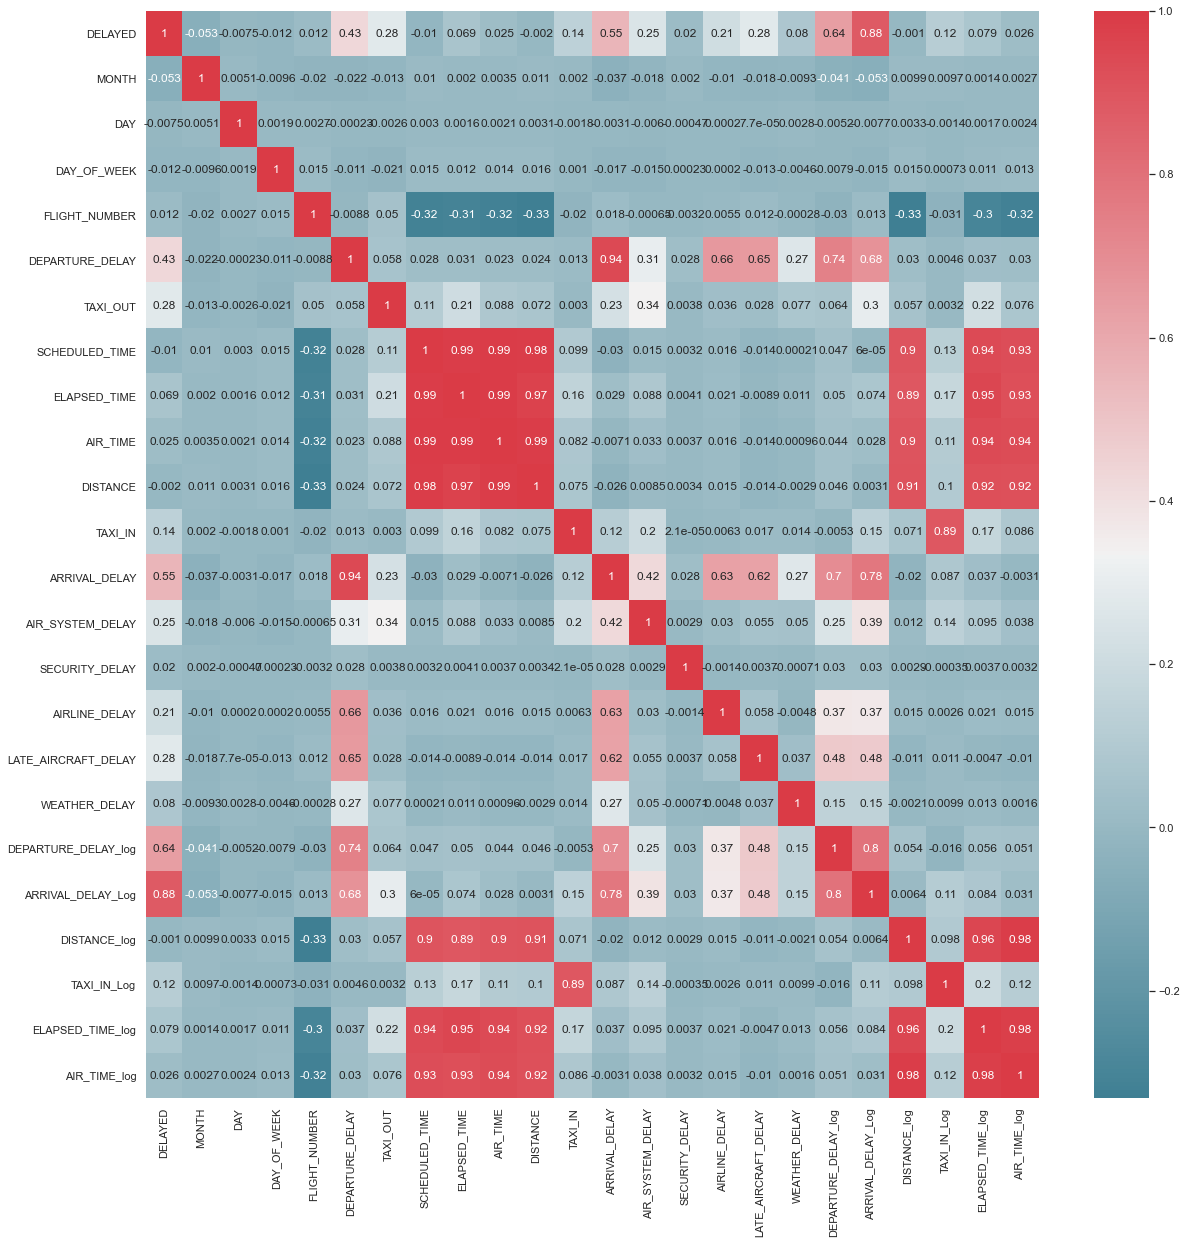

In [24]:
# Examine correlation visually using Seaborn. 
# (Code adapted from 02. Data Visualization.ipynb)

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.set(style = "darkgrid") # one of the many styles to plot using

f, ax = plt.subplots(figsize = (20, 20))

# Subset for response and continuous variables
num = df_OHE[['DELAYED', 'MONTH', 'DAY','DAY_OF_WEEK','FLIGHT_NUMBER',
          'DEPARTURE_DELAY','TAXI_OUT','SCHEDULED_TIME',
          'ELAPSED_TIME','AIR_TIME','DISTANCE',
          'TAXI_IN','ARRIVAL_DELAY','AIR_SYSTEM_DELAY',
          'SECURITY_DELAY','AIRLINE_DELAY',
          'LATE_AIRCRAFT_DELAY','WEATHER_DELAY', 'DEPARTURE_DELAY_log',
          'ARRIVAL_DELAY_Log', 'DISTANCE_log', 'TAXI_IN_Log','ELAPSED_TIME_log',
          'AIR_TIME_log']]

# Create heatmap
sns.heatmap(num.corr(), cmap=cmap, annot = True)

`SCHEDULED_TIME`, `ELAPSED_TIME`, `AIR_TIME`, `DISTANCE` are all highly correlated. However, for the log versions, only `DISTANCE_log`, `ELAPSED_TIME_log`, and `AIR_TIME_log` show high correlations to each other. Additionally, `DEPARTURE_DELAY` and `ARRIVAL_DELAY` for both the normal and log versions are also highly correlated.

Let's go through and remove one of each of these and re-run the corr plot.

<AxesSubplot:>

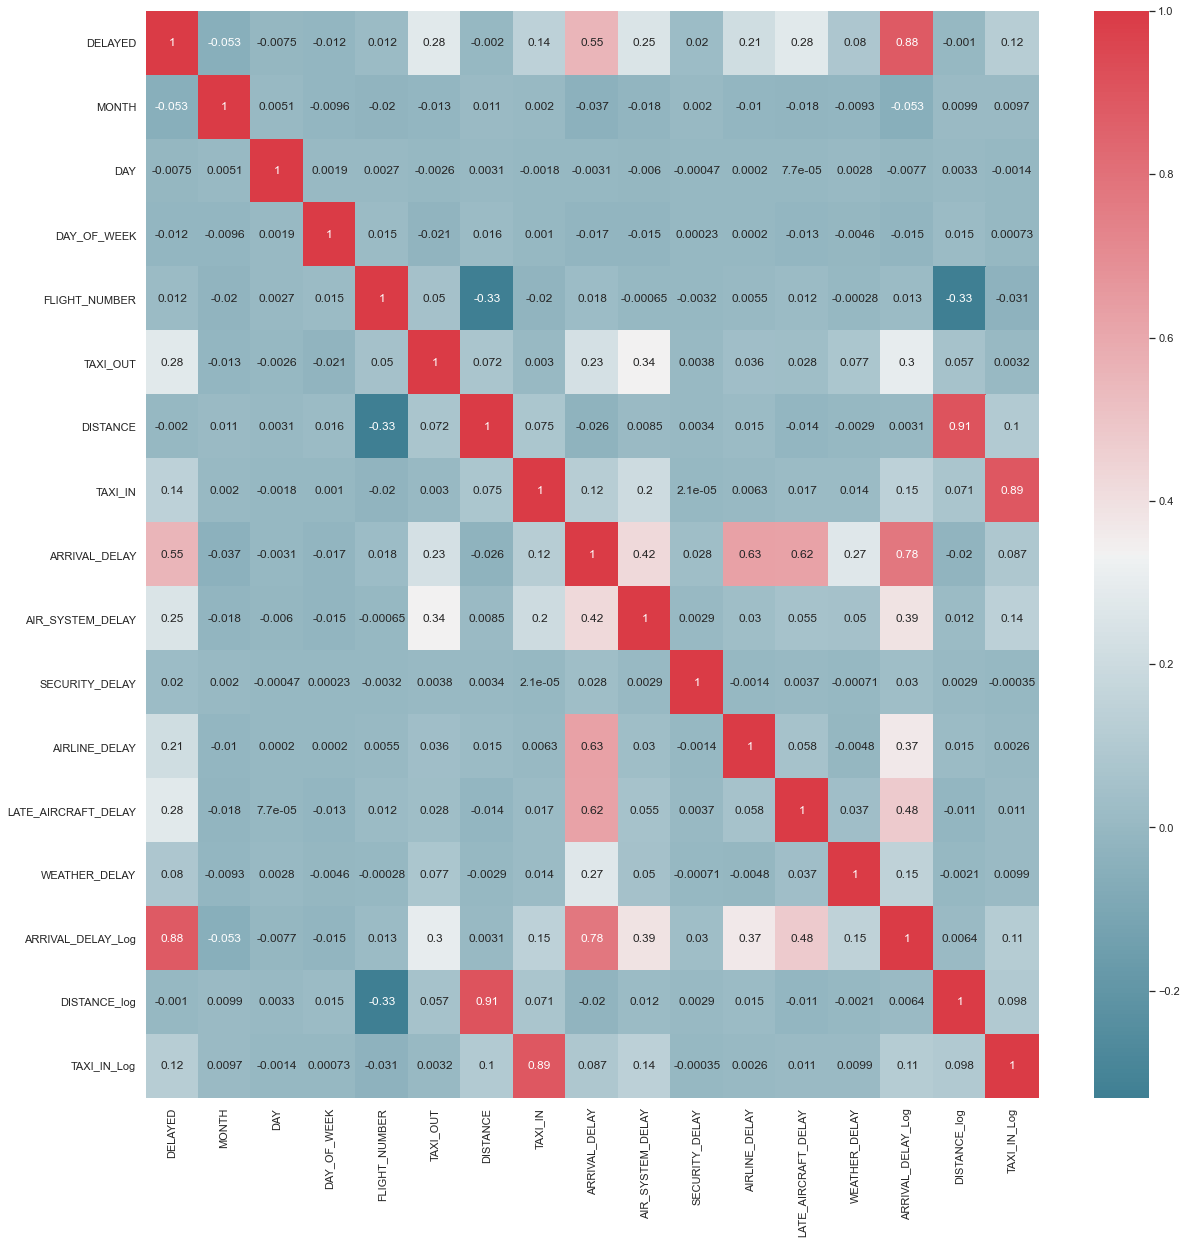

In [25]:
# Drop SCHEDULED_TIME, ELAPSED_TIME, AIR_TIME, and their log versions as well as DEPARTURE_DELAY
col_to_drop2 = ['SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME',
                'ELAPSED_TIME_log', 'AIR_TIME_log', 'DEPARTURE_DELAY', 'DEPARTURE_DELAY_log']
df_OHE = df_OHE.drop(columns = col_to_drop2)

# Examine correlation visually using Seaborn. (Code adapted from 02. Data Visualization.ipynb)
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.set(style = "darkgrid") # one of the many styles to plot using

f, ax = plt.subplots(figsize = (20, 20))

# Subset for the remaining continuous variables
num = df_OHE[['DELAYED', 'MONTH', 'DAY','DAY_OF_WEEK','FLIGHT_NUMBER',
          'TAXI_OUT','DISTANCE','TAXI_IN',
          'ARRIVAL_DELAY','AIR_SYSTEM_DELAY',
          'SECURITY_DELAY','AIRLINE_DELAY',
          'LATE_AIRCRAFT_DELAY','WEATHER_DELAY',
          'ARRIVAL_DELAY_Log', 'DISTANCE_log', 'TAXI_IN_Log']]

# Create heatmap
sns.heatmap(num.corr(), cmap=cmap, annot = True)

In [26]:
# Drop the remaining highly correlated variables DISTANCE, TAXI_IN, ARRIVAL_DELAY, and ARRIVAL_DELAY_Log
col_to_drop3 = ['DISTANCE', 'TAXI_IN', 'ARRIVAL_DELAY', 'ARRIVAL_DELAY_Log']
df_OHE = df_OHE.drop(columns = col_to_drop3)

In [27]:
df_OHE.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5709785 entries, 0 to 5709794
Data columns (total 56 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   MONTH                            int64  
 1   DAY                              int64  
 2   DAY_OF_WEEK                      int64  
 3   FLIGHT_NUMBER                    int64  
 4   TAXI_OUT                         float64
 5   DIVERTED                         int64  
 6   AIR_SYSTEM_DELAY                 float64
 7   SECURITY_DELAY                   float64
 8   AIRLINE_DELAY                    float64
 9   LATE_AIRCRAFT_DELAY              float64
 10  WEATHER_DELAY                    float64
 11  DISTANCE_log                     float64
 12  TAXI_IN_Log                      float64
 13  DELAYED                          int64  
 14  ORIGIN_AIRPORT_encode            int64  
 15  DESTINATION_AIRPORT_encode       float64
 16  TAIL_NUMBER_encode               int64  
 17  AIRLINE_

<span style="color: red;">Initial models using these variables returned a 100% accuracy which indicated a multicollinearity issue in our data. In an effort to troubleshoot it, we calculated the VIF values for our variables.</span>

In [28]:
%%time
# Re-run our VIF code
# Calculate the VIF
# Source: https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/

# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

X = df_OHE.iloc[:,:-13] # 13 is the current location of the "Delayed" response variable
calc_vif(X)

/Users/mattfarrow/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/mattfarrow/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


CPU times: user 1h 22min 56s, sys: 7min 42s, total: 1h 30min 39s
Wall time: 14min 7s


,variables,VIF
0,MONTH,1.107986
1,DAY,1.000228
2,DAY_OF_WEEK,1.003017
3,FLIGHT_NUMBER,3.576104
4,TAXI_OUT,1.336747
5,DIVERTED,NaN
6,AIR_SYSTEM_DELAY,1.216238
7,SECURITY_DELAY,1.000750
8,AIRLINE_DELAY,1.102082
9,LATE_AIRCRAFT_DELAY,1.176011


The `AIRLINE_CODE_`, `SCHED_DEPARTURE_TIME_`, `ACTUAL_DEPARTURE_TIME_`, and `SCHED_ARRIVAL_TIME_` one-hot encodings are returning perfect multicollinearity so we'll remove one of each and re-run the VIF. After thinking this through, it makes sense that the actual departure and arrival times are a dead giveaway for delays. Same with our other delay types (`AIR_SYSTEM_DELAY`, `SECURITY_DELAY`, `AIRLINE_DELAY`, `LATE_AIRCRAFT_DELAY`, `WEATHER_DELAY`, and ARRIVAL_DELAY buckets). Logically, the airline code and the scheduled times shouldn't impact our VIF, so let's remove the delay types and re-run VIF to confirm.

In [29]:
# Drop the remaining highly correlated variables DISTANCE, TAXI_IN, ARRIVAL_DELAY, and ARRIVAL_DELAY_Log
col_to_drop4 = ['ACTUAL_DEPARTURE_TIME_morning', 'ACTUAL_DEPARTURE_TIME_afternoon', 'ACTUAL_DEPARTURE_TIME_evening', 'ACTUAL_DEPARTURE_TIME_overnight', 
                'ACTUAL_ARRIVAL_TIME_morning', 'ACTUAL_ARRIVAL_TIME_afternoon', 'ACTUAL_ARRIVAL_TIME_evening', 'ACTUAL_ARRIVAL_TIME_overnight',
                'ARRIVAL_DELAY_BUCKET_Early', 'ARRIVAL_DELAY_BUCKET_On-Time', 'ARRIVAL_DELAY_BUCKET_30-59', 'ARRIVAL_DELAY_BUCKET_60-89', 'ARRIVAL_DELAY_BUCKET_90-119', 
                'ARRIVAL_DELAY_BUCKET_120+', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']
df_OHE = df_OHE.drop(columns = col_to_drop4)

df_OHE.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5709785 entries, 0 to 5709794
Data columns (total 37 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   MONTH                           int64  
 1   DAY                             int64  
 2   DAY_OF_WEEK                     int64  
 3   FLIGHT_NUMBER                   int64  
 4   TAXI_OUT                        float64
 5   DIVERTED                        int64  
 6   DISTANCE_log                    float64
 7   TAXI_IN_Log                     float64
 8   DELAYED                         int64  
 9   ORIGIN_AIRPORT_encode           int64  
 10  DESTINATION_AIRPORT_encode      float64
 11  TAIL_NUMBER_encode              int64  
 12  AIRLINE_CODE_AA                 uint8  
 13  AIRLINE_CODE_AS                 uint8  
 14  AIRLINE_CODE_B6                 uint8  
 15  AIRLINE_CODE_DL                 uint8  
 16  AIRLINE_CODE_EV                 uint8  
 17  AIRLINE_CODE_F9            

In [30]:
%%time
# Re-run our VIF code
# Calculate the VIF
# Source: https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/

# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

X = df_OHE.iloc[:,:-8] # 8 is the current location of the "Delayed" response variable
calc_vif(X)

/Users/mattfarrow/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


CPU times: user 54min 30s, sys: 3min 25s, total: 57min 55s
Wall time: 8min 26s


,variables,VIF
0,MONTH,1.107559
1,DAY,1.000161
2,DAY_OF_WEEK,1.002689
3,FLIGHT_NUMBER,3.575469
4,TAXI_OUT,1.202945
5,DIVERTED,NaN
6,DISTANCE_log,1.304592
7,TAXI_IN_Log,1.105255
8,DELAYED,1.152375
9,ORIGIN_AIRPORT_encode,1.402331


### 1.10 Test/Train Split

Our desired variable for classication will be our binary value for delay to determine whether or not a flight was delayed on arrival. To assess how well each model performs, we will use an 80/20 training/testing split on our data. 10-fold cross-validation will be used to assess the model's performance. 

In [31]:
# Prep for the split by moving the response variable to the last column.
cols = list(df_OHE.columns.values) 
cols.pop(cols.index('DELAYED')) 
df_final = df_OHE[cols+['DELAYED']]

In [32]:
from sklearn.model_selection import ShuffleSplit

# We want to predict the X and y data as follows:
if 'DELAYED' in df_final:
    y = df_final['DELAYED'].values # get the labels we want
    del df_final['DELAYED'] # get rid of the class label
    X = df_final.values # use everything else to predict
    
# Define the number of cross-validation iterations
num_cv_iterations = 10

# Define the number of instances using the length of our response variable
num_instances = len(y)

# Create the split
cv_object = ShuffleSplit(n_splits=num_cv_iterations,random_state=10,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=10, random_state=10, test_size=0.2, train_size=None)


### 1.11 Logistic Regression

<span style="color: red;">For our initial logistic regression run, we used the code found in the class notebook to run 10-fold cross-validation.</span>

In [33]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# Define our model
lr_clf = LogisticRegression(penalty='l2', 
                            C=1.0, 
                            class_weight=None,
                            solver='liblinear')

# Run the model and print the confusion matrices
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    lr_clf.fit(X[train_indices],y[train_indices])  # train object
    y_hat = lr_clf.predict(X[test_indices]) # get test set preditions

    # print the accuracy and confusion matrix 
    print("====Iteration",iter_num," ====")
    print("accuracy", mt.accuracy_score(y[test_indices],y_hat)) 
    print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))

====Iteration 0  ====
accuracy 0.7004300512190914
confusion matrix
 [[655398  70399]
 [271697 144463]]
====Iteration 1  ====
accuracy 0.6985017824664151
confusion matrix
 [[650499  74290]
 [270008 147160]]
====Iteration 2  ====
accuracy 0.6985884757482111
confusion matrix
 [[651900  72713]
 [271486 145858]]
====Iteration 3  ====
accuracy 0.7018810690770318
confusion matrix
 [[651480  73458]
 [266981 150038]]
====Iteration 4  ====
accuracy 0.6991279006127201
confusion matrix
 [[648800  76376]
 [267207 149574]]
====Iteration 5  ====
accuracy 0.7000788996433316
confusion matrix
 [[657982  66608]
 [275889 141478]]
====Iteration 6  ====
accuracy 0.6973844023899324
confusion matrix
 [[657383  67939]
 [277635 139000]]
====Iteration 7  ====
accuracy 0.6994300135644337
confusion matrix
 [[648890  76792]
 [266446 149829]]
====Iteration 8  ====
accuracy 0.6998643556631292
confusion matrix
 [[653778  71065]
 [271677 145437]]
====Iteration 9  ====
accuracy 0.6992084640665104
confusion matrix
 [[652

<span style="color: red;">Looking at the confusion matrices, 10-fold cross-validation produces an accuracy score around 69-70%. We then tried tuning the hyperparameters of the data using GridSearchCV to see if that improves our accuracy, but the size of our data set may that computationally impossible.</span>

In [ ]:
# interpret the weights

# iterate over the coefficients
weights = lr_clf.coef_.T # take transpose to make a column vector
variable_names = df_final.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])

In [ ]:
df_final.info()

In [ ]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'DELAYED' in df_final:
    y = df_final['DELAYED'].values # get the labels we want
    del df_final['DELAYED'] # get rid of the class label
    X = df_final.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         random_state=10,
                         test_size  = 0.2)
                         
print(cv_object)

In [ ]:
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    lr_clf.fit(X[train_indices],y[train_indices])  # train object
    y_hat = lr_clf.predict(X[test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print("====Iteration",iter_num," ====")
    print("accuracy", mt.accuracy_score(y[test_indices],y_hat)) 
    print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))

If this still overfits, we should remove the other delay types as those also are somewhat redundant as if they are non-zero, then typically the arrival delay will be `1`. Another alternative could be ridge regression or lasso for variable selection.

In [ ]:
# Consider running variable importance here

### 1.12 SVM

Run 'out of the box' SVM. Note that we have not scaled the data. Our data is all roughly on the same scale to begin with and should not be necessary.

In [ ]:
# from sklearn.svm import SVC
# svm_clf = SVC()

# for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
#     svm_clf.fit(X[train_indices],y[train_indices])  # train object
#     y_hat = svm_cfl.predict(X[test_indices]) # get test set precitions

#     # print the accuracy and confusion matrix 
#     print("====Iteration",iter_num," ====")
#     print("accuracy", mt.accuracy_score(y[test_indices],y_hat)) 
#     print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))

In [ ]:
# # Code adapated from: https://stackoverflow.com/questions/31681373/making-svm-run-faster-in-python
# import time
# import numpy as np
# from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
# from sklearn import datasets
# from sklearn.multiclass import OneVsRestClassifier
# from sklearn.svm import SVC

# # iris = datasets.load_iris()
# # X, y = iris.data, iris.target

# # X = np.repeat(X, 100, axis=0)
# # y = np.repeat(y, 100, axis=0)
# start = time.time()
# clf = OneVsRestClassifier(SVC(kernel='linear', probability=True, class_weight='auto'))
# clf.fit(X, y)
# end = time.time()
# print "Single SVC", end - start, clf.score(X,y)
# proba = clf.predict_proba(X)

# n_estimators = 10
# start = time.time()
# clf = OneVsRestClassifier(BaggingClassifier(SVC(kernel='linear', probability=True, class_weight='auto'), max_samples=1.0 / n_estimators, n_estimators=n_estimators))
# clf.fit(X, y)
# end = time.time()
# print "Bagging SVC", end - start, clf.score(X,y)
# proba = clf.predict_proba(X)

# start = time.time()
# clf = RandomForestClassifier(min_samples_leaf=20)
# clf.fit(X, y)
# end = time.time()
# print "Random Forest", end - start, clf.score(X,y)
# proba = clf.predict_proba(X)

In [ ]:
%%time
# use some compact notation for creating a linear SVM classifier with stichastic descent
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier

regularize_const = 0.1
iterations = 5
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in cv_object.split(X,y):
    svm_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = svm_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print('SVM:', acc)

## 2. Advantages of Each Model

[10 points] Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.

## 3. Feature Importance

[30 points] Use the weights from logistic regression to interpret the importance of different features for each classification task. Explain your interpretation in detail. Why do you think some variables are more important?

## 4. Support Vectors

[10 points] Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain.

## Matt's Hot Mess

In [ ]:
# # Source: https://towardsdatascience.com/logistic-regression-model-tuning-with-scikit-learn-part-1-425142e01af5

# from sklearn.ensemble import RandomForestClassifier
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# # Create first pipeline for base without reducing features.

# pipe = Pipeline([('classifier' , RandomForestClassifier())])

# # Create param grid

# param_grid = [
#     {'classifier' : [LogisticRegression()],
#      'classifier__penalty' : ['l1', 'l2'],
#     'classifier__C' : np.logspace(-4, 4, 20),
#     'classifier__solver' : ['liblinear']},
#     {'classifier' : [RandomForestClassifier()],
#     'classifier__n_estimators' : list(range(10,101,10)),
#     'classifier__max_features' : list(range(6,32,5))}
# ]

# # Create grid search object

# clf = GridSearchCV(pipe, param_grid = param_grid, cv = 1, verbose=True, n_jobs=-1)

# # Fit on data

# best_clf = clf.fit(X[train_indices], y[train_indices])

In [ ]:
# # Source: https://vitalflux.com/randomized-search-explained-python-sklearn-example/

# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.pipeline import make_pipeline
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import GridSearchCV
# from sklearn.svm import SVC
# import scipy as sc

# # Create training and test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# # Create the pipeline estimator
# pipeline = make_pipeline(StandardScaler(), SVC(random_state=1))

# # Create parameter distribution using scipy.stats module
# param_distributions = [{'svc__C': sc.stats.expon(scale=100),
#                         'svc__gamma': sc.stats.expon(scale=.1),
#                         'svc__kernel': ['rbf']},
#                        {'svc__C': sc.stats.expon(scale=100),
#                         'svc__kernel': ['linear']}]

# # Create an instance of RandomizedSearchCV
# rs = RandomizedSearchCV(estimator=pipeline, param_distributions = param_distributions,
#                         cv = 10, scoring = 'accuracy', refit = True, n_jobs = 1,
#                        random_state=1)
# #
# # Fit the RandomizedSearchCV estimator
# rs.fit(X_train, y_train)

In [ ]:
# print('Test Accuracy: %0.3f' % rs.score(X_test, y_test))